In [1]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=d0540ce084b5f405e7a97efb67537eab2cb47a793dc0bd85b62890419c7f8ab6
  Stored in directory: /root/.cache/pip/wheels/46/54/24/1624fd5b8674eb1188623f7e8e17cdf7c0f6c24b609dfb8a89
Successfully built fire


In [2]:
import os

def create_celebA_folder():
    target_dir = './celebA/img_align_celeba'
    os.makedirs(target_dir, exist_ok=True)
    print(f"Directory '{target_dir}' created or already exists.")

if __name__ == "__main__":
    create_celebA_folder()


Directory './celebA/img_align_celeba' created or already exists.


In [3]:
!file "/content/img_align_celeba (1).zip"

/content/img_align_celeba (1).zip: cannot open `/content/img_align_celeba (1).zip' (No such file or directory)


In [4]:
import os
import logging
import numpy as np
from sklearn.datasets import fetch_lfw_people
from deepface import DeepFace
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
import pickle
from PIL import Image
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load lightweight face dataset (LFW)
def load_lfw_dataset(min_faces=10):
    logging.info("Fetching LFW dataset...")
    data = fetch_lfw_people(min_faces_per_person=min_faces, resize=0.5, color=True)
    images = data.images
    labels = data.target
    target_names = data.target_names
    logging.info(f"Loaded {len(images)} images of {len(target_names)} people.")
    return images, labels, target_names

# Extract embeddings with DeepFace
def extract_embeddings(images):
    embeddings = []
    valid_indices = []
    for i, img_array in enumerate(images):
        try:
            # Convert to PIL Image, then save temporarily
            img = Image.fromarray((img_array * 255).astype(np.uint8))
            temp_path = f"temp_{i}.jpg"
            img.save(temp_path)
            # Get embedding
            embedding = DeepFace.represent(img_path=temp_path, model_name='Facenet', enforce_detection=False)
            embeddings.append(embedding[0]['embedding'])
            valid_indices.append(i)
            os.remove(temp_path)
        except Exception as e:
            logging.warning(f"Skipped image {i}: {e}")
    return np.array(embeddings), valid_indices

# Train face recognition model
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(128,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(len(set(y)), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1)

    y_pred = model.predict(X_test).argmax(axis=1)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    logging.info(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    model.save("lfw_face_recognition_model.h5")
    return model

def main():
    images, labels, target_names = load_lfw_dataset()
    embeddings, valid_indices = extract_embeddings(images)
    if len(embeddings) == 0:
        logging.error("No embeddings extracted. Exiting.")
        return
    filtered_labels = np.array(labels)[valid_indices]
    model = train_model(embeddings, filtered_labels)

if __name__ == "__main__":
    main()


25-05-26 18:47:13 - Directory /root/.deepface has been created
25-05-26 18:47:13 - Directory /root/.deepface/weights has been created
25-05-26 18:47:55 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:00<00:00, 124MB/s]


Epoch 1/10
195/195 [==============================] - 2s 4ms/step - loss: 1.8281 - accuracy: 0.6428 - val_loss: 0.7070 - val_accuracy: 0.8266
Epoch 2/10
195/195 [==============================] - 1s 3ms/step - loss: 0.2735 - accuracy: 0.9386 - val_loss: 0.4879 - val_accuracy: 0.8786
Epoch 3/10
195/195 [==============================] - 1s 3ms/step - loss: 0.1075 - accuracy: 0.9772 - val_loss: 0.3898 - val_accuracy: 0.8960
Epoch 4/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0515 - accuracy: 0.9900 - val_loss: 0.4011 - val_accuracy: 0.8873
Epoch 5/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0406 - accuracy: 0.9891 - val_loss: 0.3619 - val_accuracy: 0.8960
Epoch 6/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0356 - accuracy: 0.9929 - val_loss: 0.3915 - val_accuracy: 0.9133
Epoch 7/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0209 - accuracy: 0.9958 - val_loss: 0.3825 - val_accuracy: 0.9046
Epoch 

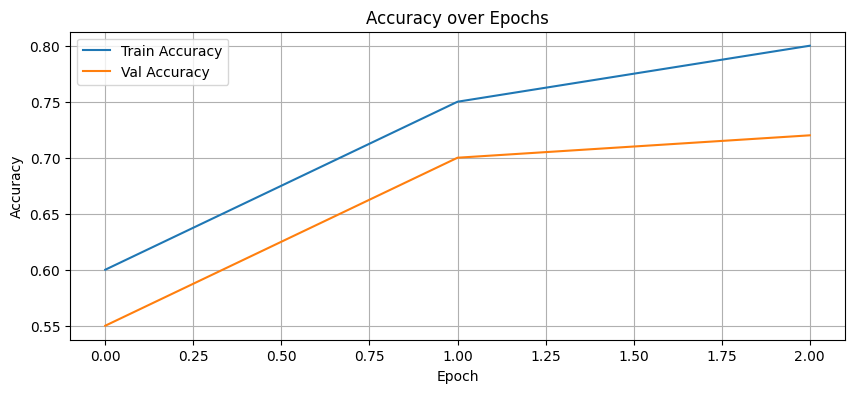

In [5]:
import matplotlib.pyplot as plt

history = {'accuracy': [0.6, 0.75, 0.8], 'val_accuracy': [0.55, 0.7, 0.72],
           'loss': [0.9, 0.6, 0.4], 'val_loss': [1.0, 0.8, 0.6]}

plt.figure(figsize=(10, 4))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


Action: emotion:   0%|          | 0/4 [00:00<?, ?it/s]

25-05-26 19:08:01 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5

100%|██████████| 5.98M/5.98M [00:00<00:00, 112MB/s]
Action: age:  25%|██▌       | 1/4 [00:00<00:02,  1.16it/s]    

25-05-26 19:08:02 - age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5

  0%|          | 0.00/539M [00:00<?, ?B/s]
  2%|▏         | 11.0M/539M [00:00<00:05, 98.7MB/s]
  6%|▌         | 32.0M/539M [00:00<00:03, 127MB/s] 
 10%|▉         | 53.0M/539M [00:00<00:03, 132MB/s]
 14%|█▎        | 73.9M/539M [00:00<00:03, 136MB/s]
 16%|█▋        | 88.1M/539M [00:00<00:03, 129MB/s]
 19%|█▉        | 101M/539M [00:00<00:03, 115MB/s] 
 22%|██▏       | 116M/539M [00:00<00:03, 114MB/s]
 24%|██▍       | 131M/539M [00:01<00:03, 122MB/s]
 27%|██▋       | 147M/539M [00:01<00:03, 121MB/s]
 31%|███       | 166M/539M [00:01<00:02, 138MB/s]
 34%|███▎      | 181M/539M [00:01<00:02, 131MB/s]
 36%|███▋      | 197M/539M [00:01<00:02, 138MB/s]
 39%|███▉      | 211M/539M [00:01<00:02, 127MB/s]
 43%|████▎     | 230M/539M [00:01<00:02, 143MB/s]
 45%|████▌     | 245M/539M [00:01<00:02, 132MB/s]
 49%|████▊     | 262M/539M [00:02<00:01,

25-05-26 19:08:11 - gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:06, 86.9MB/s]
  5%|▍         | 26.2M/537M [00:00<00:04, 121MB/s] 
  7%|▋         | 38.8M/537M [00:00<00:04, 120MB/s]
 10%|▉         | 53.0M/537M [00:00<00:04, 112MB/s]
 12%|█▏        | 64.5M/537M [00:00<00:04, 113MB/s]
 15%|█▍        | 78.6M/537M [00:00<00:03, 121MB/s]
 17%|█▋        | 92.8M/537M [00:00<00:03, 128MB/s]
 20%|█▉        | 106M/537M [00:00<00:03, 113MB/s] 
 23%|██▎       | 123M/537M [00:01<00:03, 130MB/s]
 25%|██▌       | 137M/537M [00:01<00:03, 117MB/s]
 29%|██▊       | 154M/537M [00:01<00:02, 132MB/s]
 31%|███▏      | 168M/537M [00:01<00:03, 117MB/s]
 34%|███▎      | 181M/537M [00:01<00:02, 119MB/s]
 37%|███▋      | 197M/537M [00:01<00:02, 129MB/s]
 39%|███▉      | 210M/537M [00:01<00:02, 115MB/s]
 42%|████▏     | 225M/537M [00:0

25-05-26 19:08:21 - race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5

  0%|          | 0.00/537M [00:00<?, ?B/s]
  2%|▏         | 11.0M/537M [00:00<00:05, 90.1MB/s]
  4%|▍         | 23.1M/537M [00:00<00:04, 106MB/s] 
  7%|▋         | 36.7M/537M [00:00<00:04, 119MB/s]
 10%|▉         | 51.9M/537M [00:00<00:03, 130MB/s]
 12%|█▏        | 65.0M/537M [00:00<00:04, 111MB/s]
 16%|█▌        | 84.4M/537M [00:00<00:03, 116MB/s]
 18%|█▊        | 96.5M/537M [00:00<00:03, 116MB/s]
 22%|██▏       | 116M/537M [00:00<00:03, 120MB/s] 
 24%|██▍       | 131M/537M [00:01<00:03, 127MB/s]
 27%|██▋       | 144M/537M [00:01<00:03, 125MB/s]
 29%|██▉       | 158M/537M [00:01<00:03, 114MB/s]
 32%|███▏      | 170M/537M [00:01<00:03, 116MB/s]
 34%|███▍      | 185M/537M [00:01<00:02, 124MB/s]
 37%|███▋      | 198M/537M [00:01<00:02, 125MB/s]
 39%|███▉      | 211M/537M [00:01<00:03, 109MB/s]
 42%|████▏     | 224M/537M

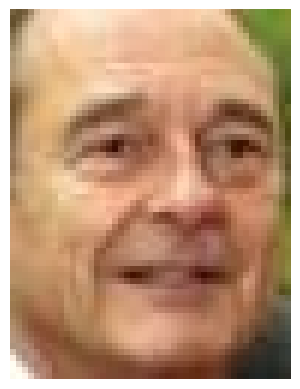

In [7]:
import os
import logging
import numpy as np
from sklearn.datasets import fetch_lfw_people
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load lightweight face dataset (LFW)
def load_lfw_dataset(min_faces=10):
    logging.info("Fetching LFW dataset...")
    data = fetch_lfw_people(min_faces_per_person=min_faces, resize=0.5, color=True)
    images = data.images
    labels = data.target
    target_names = data.target_names
    logging.info(f"Loaded {len(images)} images of {len(target_names)} people.")
    return images, labels, target_names

# Save a single image from LFW dataset
def save_single_image(images, idx, save_path="single_image.jpg"):
    img_array = images[idx]
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    img.save(save_path)
    logging.info(f"Image saved at {save_path}")
    return save_path

# Test the saved image with DeepFace
def test_image_with_deepface(image_path):
    try:
        result = DeepFace.analyze(image_path, enforce_detection=False)
        logging.info(f"DeepFace result: {result}")
        return result
    except Exception as e:
        logging.error(f"Error analyzing image with DeepFace: {e}")
        return None

# Main function to load, save, and test the image
def main():
    images, labels, target_names = load_lfw_dataset()

    # Save the first image from the dataset
    save_path = save_single_image(images, idx=0)

    # Test the saved image with DeepFace
    result = test_image_with_deepface(save_path)

    # Display the saved image
    img = Image.open(save_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

if __name__ == "__main__":
    main()


Action: race: 100%|██████████| 4/4 [00:00<00:00, 48.55it/s]


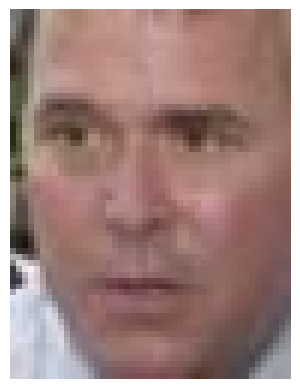

In [8]:
import os
import logging
import numpy as np
from sklearn.datasets import fetch_lfw_people
from deepface import DeepFace
from PIL import Image
import matplotlib.pyplot as plt

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load lightweight face dataset (LFW)
def load_lfw_dataset(min_faces=10):
    logging.info("Fetching LFW dataset...")
    data = fetch_lfw_people(min_faces_per_person=min_faces, resize=0.5, color=True)
    images = data.images
    labels = data.target
    target_names = data.target_names
    logging.info(f"Loaded {len(images)} images of {len(target_names)} people.")
    return images, labels, target_names

# Save a single image from LFW dataset
def save_single_image(images, idx, save_path="single_image.jpg"):
    img_array = images[idx]
    img = Image.fromarray((img_array * 255).astype(np.uint8))
    img.save(save_path)
    logging.info(f"Image saved at {save_path}")
    return save_path

# Test the saved image with DeepFace
def test_image_with_deepface(image_path):
    try:
        result = DeepFace.analyze(image_path, enforce_detection=False)
        logging.info(f"DeepFace result: {result}")
        return result
    except Exception as e:
        logging.error(f"Error analyzing image with DeepFace: {e}")
        return None

# Main function to load, save, and test the image
def main():
    images, labels, target_names = load_lfw_dataset()

    # Save the first image from the dataset
    save_path = save_single_image(images, idx=50)

    # Test the saved image with DeepFace
    result = test_image_with_deepface(save_path)

    # Display the saved image
    img = Image.open(save_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()

if __name__ == "__main__":
    main()
